In [1]:
from framework.simulation import FaradayThinSource,FaradayThickSource
from framework.reconstruction import Parameter
import numpy as np
from IPython.display import clear_output
from framework.io import Reader, Writer
from framework.base import Dataset
from framework.transformers import DFT1D, NUFFT1D
import matplotlib.pyplot as plt
from framework.objectivefunction import OFunction
from framework.utils import real_to_complex, complex_to_real
from framework.objectivefunction import TSV, TV, L1, Chi2
from framework.optimization import FISTA, ADMM, SDMM, GradientBasedMethod
from framework.utils import Gaussian
from framework.dictionaries.discrete import DiscreteWavelet
from framework.dictionaries.undecimated import UndecimatedWavelet
from framework.transformers import Gridding
from scipy.constants import c
from pynufft import NUFFT
from scipy import signal as sci_signal
import itertools
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as un
from astropy.stats import sigma_clipped_stats
from hampel import hampel
import pandas as pd

In [2]:
def median_absolute_deviation(x):
    """
    Returns the median absolute deviation from the window's median
    :param x: Values in the window
    :return: MAD
    """
    return np.median(np.abs(x - np.median(x)))

In [3]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [4]:
def halper(array, w, nsigma, imputation=False):
    k = 1.4826
    array_copy = array.copy()
    rolling_mean = moving_average(array_copy, w)
    rolling_median = np.median(rolling_mean)
    rolling_sigma = k * median_absolute_deviation(rolling_mean)
    preserved_idxs = np.where(np.abs(array_copy - rolling_median) <= (nsigma * rolling_sigma))
    outlier_idxs = np.where(np.abs(array_copy - rolling_median) > (nsigma * rolling_sigma))
    if imputation:
        array_copy[outlier_idxs] = rolling_median[outlier_idxs]
        return array_copy, preserved_idxs, outlier_idxs
    else:
        return preserved_idxs, outlier_idxs
        

In [5]:
def normal_flagging(x, nsigma):
    mean_sigma = np.mean(x)
    std_err = np.std(x)/np.sqrt(len(x))
    preserved_idxs = np.where(sigma_qu <= mean_sigma + nsigma*std_err)
    outlier_idxs = np.where(sigma_qu > mean_sigma + nsigma*std_err)
    return preserved_idxs, outlier_idxs 

In [6]:
# Read cubes
Q_name = "/home/miguel/Documents/datasets/A1314_JVLA/cubes/A1314_Q_corrected.fits"
U_name = "/home/miguel/Documents/datasets/A1314_JVLA/cubes/A1314_U_corrected.fits"

hdul_q = fits.open(Q_name, memmap=True)
hdul_u = fits.open(U_name, memmap=True)

In [7]:
# Read spectral index
spc_idx_name = "/home/miguel/Documents/datasets/A1314_JVLA/cubes/alpha_0.fits"
hdul_alpha = fits.open(spc_idx_name, memmap=True)

In [8]:
# Read frequencies
freq_name = "/home/miguel/Documents/datasets/A1314_JVLA/cubes/freqs.npy"
freqs = np.load(freq_name)

In [9]:
# Get LOS
coord = SkyCoord("11:33:59.1755+49:03:44.108", unit=(un.hourangle, un.deg), frame="fk5")

In [10]:
# Get WCS
wcs = WCS(hdul_q[0].header)

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [11]:
# Get pixel
x,y = coord.to_pixel(wcs, origin=0)
x = int(x)
y = int(y)

In [12]:
q_data = hdul_q[0].data
u_data = hdul_u[0].data

In [13]:
# Get sigma
mean_q, median_q, std_q = sigma_clipped_stats(q_data, sigma=3, axis=(1,2))
mean_u, median_u, std_u = sigma_clipped_stats(u_data, sigma=3, axis=(1,2))

In [14]:
sigma_qu = 0.5*(std_q+std_u)
mean_sigma = np.mean(sigma_qu)
std_err = np.std(sigma_qu)/np.sqrt(len(sigma_qu))

(array([254., 204.,  89.,  56.,  20.,  15.,  14.,   2.,   8.,   1.,   3.,
          0.,   4.,   1.,   2.,   1.,   1.,   0.,   0.,   0.,   2.,   0.,
          1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   1.,   0.,   1.]),
 array([0.00029528, 0.00036751, 0.00043975, 0.00051198, 0.00058421,
        0.00065644, 0.00072867, 0.00080091, 0.00087314, 0.00094537,
        0.0010176 , 0.00108983, 0.00116207, 0.0012343 , 0.00130653,
        0.00137876, 0.00145099, 0.00152323, 0.00159546, 0.00166769,
        0.00173992, 0.00181215, 0.00188439, 0.00195662, 0.00202885,
        0.00210108, 0.00217331, 0.00224555, 0.00231778, 0.00239001,
        0.00246224, 0.00253447, 0.00260671, 0.00267894, 0.00275117,
        0.0028234 , 0.00289563, 0.00296787, 0.0030401 , 0.00311233,
        0.00318456, 0.00325679, 0.00332903, 0.00340126, 0.00347349,
        0.00354572, 0.00361795, 0.00369019, 0.

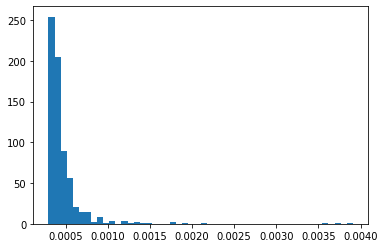

In [15]:
plt.hist(sigma_qu, bins=50)

In [76]:
#preserved_idxs, outlier_idxs = halper(sigma_qu, 3, 3)
preserved_idxs_normal, outlier_idxs_normal = normal_flagging(sigma_qu, 2.0)

In [77]:
#idx = preserved_idxs
idx = preserved_idxs_normal

In [78]:
freqs_flagged = freqs[idx]

In [79]:
# Get data
q = np.flipud(q_data[idx])
u = np.flipud(u_data[idx])

In [80]:
std_q_flagged = std_q[idx]
std_u_flagged = std_u[idx]

In [81]:
data = q[:,y,x] + 1j * u[:,y,x]
alpha = hdul_alpha[0].data[y,x]
sigma = 0.5*(std_q_flagged + std_u_flagged)

(array([ 3.,  2.,  8., 16., 13., 24., 22., 20., 21., 11.,  9.,  8., 11.,
        11., 12., 18., 10., 14., 17., 11., 31., 21., 25., 20., 14., 16.,
        13., 10.,  9.,  7.,  4.,  1.,  7.,  5.,  2.,  1.,  3.,  5.,  4.,
         8.,  4.,  1.,  3.,  4.,  6.,  4.,  3.,  4., 10.,  7.]),
 array([0.00029528, 0.00029901, 0.00030274, 0.00030647, 0.0003102 ,
        0.00031393, 0.00031766, 0.00032139, 0.00032512, 0.00032885,
        0.00033258, 0.00033631, 0.00034004, 0.00034377, 0.0003475 ,
        0.00035123, 0.00035496, 0.00035869, 0.00036242, 0.00036615,
        0.00036988, 0.00037361, 0.00037734, 0.00038107, 0.0003848 ,
        0.00038853, 0.00039226, 0.00039599, 0.00039972, 0.00040345,
        0.00040718, 0.00041091, 0.00041464, 0.00041837, 0.0004221 ,
        0.00042583, 0.00042956, 0.00043329, 0.00043702, 0.00044075,
        0.00044448, 0.00044821, 0.00045194, 0.00045567, 0.0004594 ,
        0.00046313, 0.00046686, 0.00047059, 0.00047433, 0.00047806,
        0.00048179]),
 <BarContainer

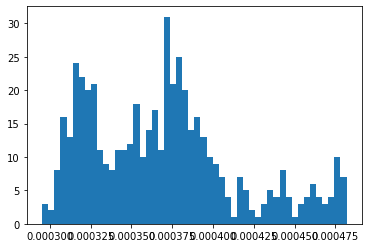

In [82]:
plt.hist(sigma, bins=50)

In [83]:
measurements = Dataset(nu=freqs_flagged, data=data, sigma=sigma, spectral_idx=alpha)

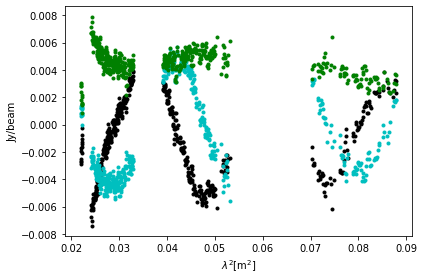

In [84]:
plt.plot(measurements.lambda2, measurements.data.real, 'k.', label=r"Stokes $Q$")
plt.plot(measurements.lambda2, measurements.data.imag, 'c.', label=r"Stokes $U$")
plt.plot(measurements.lambda2, np.abs(measurements.data), 'g.', label=r"$|P|$")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'Jy/beam')
#plt.legend(loc='upper right')
plt.tight_layout()
#plt.savefig('polarized.png', dpi=100, bbox_inches='tight')

Text(0, 0.5, '1/(Jy/beam)$^2$')

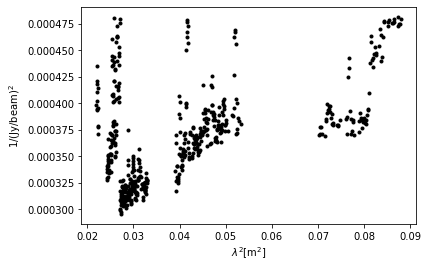

In [88]:
plt.plot(measurements.lambda2, measurements.sigma, 'k.', label=r"$\sigma$")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'1/(Jy/beam)$^2$')

In [56]:
parameter = Parameter()

In [57]:
parameter.calculate_cellsize(dataset=measurements)

FWHM of the main peak of the RMTF: 54.359 rad/m^2
Maximum recovered width structure: 129.799 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 13345.019


In [58]:
nufft = NUFFT1D(dataset=measurements, parameter=parameter, solve=True)

In [59]:
dft = DFT1D(dataset=measurements, parameter=parameter)

In [60]:
F_dirty = dft.backward(measurements.data)

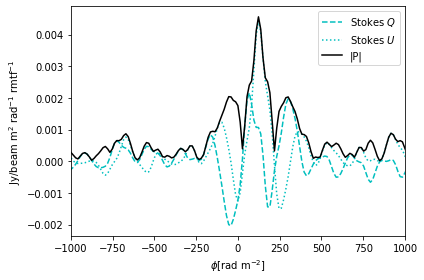

In [61]:
plt.plot(parameter.phi, F_dirty.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, F_dirty.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(F_dirty), 'k-', label=r"|P|")
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.xlim([-1000,1000])
plt.tight_layout()
plt.savefig('fdirty.png', dpi=100, bbox_inches='tight')

In [62]:
idx_noise = np.where(np.abs(parameter.phi)>8000)
noise_F = np.std(0.5*(F_dirty[idx_noise].real + F_dirty[idx_noise].imag))
noise_F

4.7366004e-05

In [63]:
noise_weights = 1/np.sqrt(np.sum(measurements.w))
noise_weights

1.6159310391734595e-05

In [64]:
parameter.data = F_dirty

In [65]:
parameter.complex_data_to_real()

In [66]:
lambda_l1 = np.sqrt(2 * len(measurements.data) + np.sqrt(4 * len(measurements.data))) * noise_weights
#lambda_l1 = np.sqrt(len(measurements.data)) * noise_F
#lambda_l1 /= 10
#lambda_l1=0.5
lambda_tsv = 0.0
chi2 = Chi2(dft_obj=nufft)
l1 = L1(reg=lambda_l1)
tsv = TSV(reg=lambda_tsv)
# F_func = [chi2(P, dft, W), L1(lambda_l1)]
F_func = [chi2, l1, tsv]
f_func = [chi2]
g_func = [l1, tsv]

F_obj = OFunction(F_func)
f_obj = OFunction(f_func)
g_obj = OFunction(g_func)

In [67]:
opt = FISTA(guess_param=parameter, F_obj=F_obj, fx=chi2, gx=g_obj, noise=noise_weights, verbose=True)
#opt = FISTA(i_guess=F_real, F_obj=F_obj, fx=chi2, gx=g_obj, maxiter=1000, noise=1e-5, verbose=True)
obj, X = opt.run()

Iterations set to 32
Iteration:  0  objective function value: 15599.16831


In [68]:
X.real_data_to_complex()

(-1000.0, 1000.0)

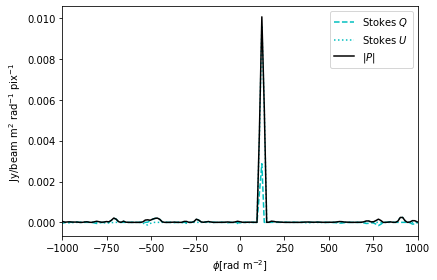

In [69]:
plt.plot(parameter.phi, X.data.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, X.data.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(X.data), 'k-', label=r"$|P|$")
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ pix$^{-1}$')
plt.legend(loc='upper right')
plt.tight_layout()
plt.xlim([-1000,1000])

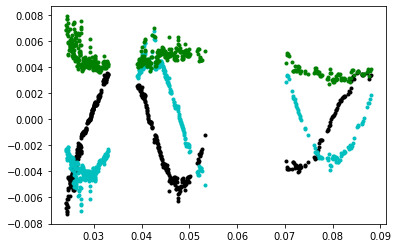

In [70]:
plt.plot(measurements.lambda2, measurements.model_data.real, 'k.', label=r"Stokes $Q$")
plt.plot(measurements.lambda2, measurements.model_data.imag, 'c.', label=r"Stokes $U$")
plt.plot(measurements.lambda2, np.abs(measurements.model_data), 'g.', label=r"$|P|$")
#plt.ylim([-0.007,0.008])

(-1000.0, 1000.0)

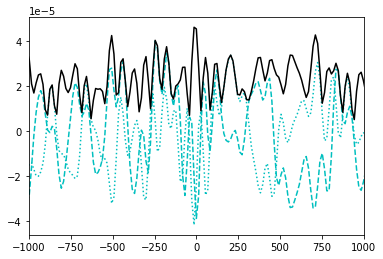

In [71]:
F_residual = nufft.backward(measurements.residual)
plt.plot(parameter.phi, F_residual.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, F_residual.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(F_residual), 'k-', label=r"$|P|$")
plt.xlim([-1000,1000])

In [72]:
conv_model = X.convolve(normalized=True) + F_residual

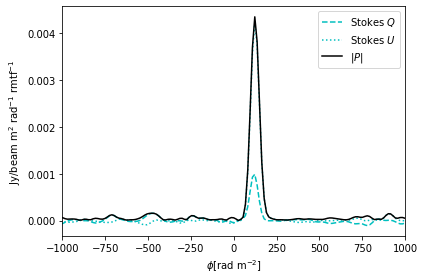

In [73]:
plt.plot(parameter.phi, conv_model.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, conv_model.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(conv_model), 'k-', label=r"$|P|$")
plt.xlim([-1000,1000])
#plt.axhline (y = noise_weights, color = 'b')
#plt.axhline (y = -noise_weights, color = 'b')
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.tight_layout()

In [74]:
phi_idx = np.argmax(np.abs(conv_model))
parameter.phi[phi_idx]

123.05857473217262

In [75]:
np.max(np.abs(conv_model))

0.004354472225201213